In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml import Pipeline
from pyspark.ml.feature import  StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import size
from pyspark_dist_explore import hist # install
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd 
import math

%matplotlib inline

In [2]:
spark= SparkSession \
        .builder \
        .appName("Data Preparation1")\
        .getOrCreate()


In [3]:
spark.version

'3.3.2'

## Data collecting 

In [4]:
# This cell runs once to download the data 

import opendatasets as od  # install
 
od.download(
    "https://www.kaggle.com/datasets/saurabhshahane/twitter-sentiment-dataset", force=True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mohamedabdelrazek9
Your Kaggle Key: ········


100%|██████████| 7.60M/7.60M [00:00<00:00, 12.4MB/s]


In [5]:
dataTrain=spark.read.csv(r'twitter-sentiment-dataset\Twitter_Data.csv',header =True)


In [6]:
dataTrain.show()

+--------------------+--------+
|          clean_text|category|
+--------------------+--------+
|when modi promise...|      -1|
|talk all the nons...|       0|
|what did just say...|       1|
|asking his suppor...|       1|
|answer who among ...|       1|
|kiya tho refresh ...|       0|
|surat women perfo...|    null|
|                  ,0|    null|
|this comes from c...|       0|
|with upcoming ele...|       1|
|gandhi was gay do...|       1|
|things like demon...|       1|
|hope tuthukudi pe...|       1|
|calm waters where...|       1|
|one vote can make...|       0|
|one vote can make...|       0|
|vote such party a...|      -1|
|vote modi who has...|       0|
|through our vote ...|       0|
|dont play with th...|    null|
+--------------------+--------+
only showing top 20 rows



In [7]:
dataTrain.groupBy('Category').count().show()

+--------+-----+
|Category|count|
+--------+-----+
|      -1|34665|
|       0|53553|
|    null|33437|
|       1|70476|
+--------+-----+



* In this table we see that there are many nulls and our data composit from two columns target and tweets so we can drop them or dealing with them as test data

In [8]:
df=dataTrain.toPandas()
# px.histogram( df,x= 'category',title='Data Distibution')


In [9]:
df["category"].value_counts()

1     70476
0     53553
-1    34665
Name: category, dtype: int64

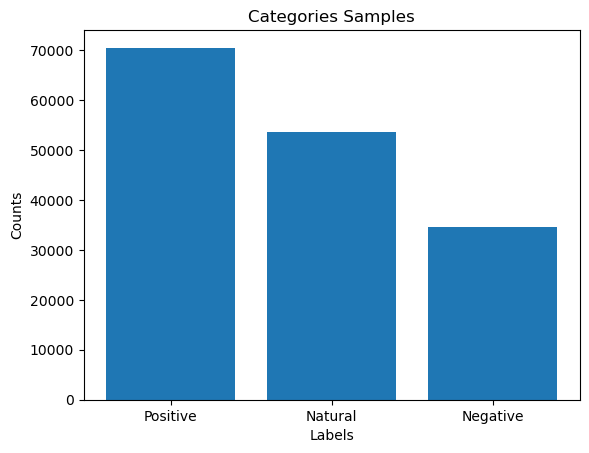

In [10]:
plt.bar(['Positive', "Natural", "Negative"], df["category"].value_counts())
plt.title("Categories Samples")
plt.xlabel("Labels")
plt.ylabel("Counts")
plt.show()

## Data cleaning

In [11]:
xData=dataTrain[dataTrain['Category']!='null']

In [12]:
xData.groupBy('Category').count().show()

+--------+-----+
|Category|count|
+--------+-----+
|      -1|34665|
|       0|53553|
|       1|70476|
+--------+-----+



In [13]:
xData = xData.withColumnRenamed("clean_text","Tweet")

indexer = StringIndexer(inputCol='category', outputCol='label')
indexd_data=indexer.fit(xData).transform(xData)
indexd_data.show()

+--------------------+--------+-----+
|               Tweet|category|label|
+--------------------+--------+-----+
|when modi promise...|      -1|  2.0|
|talk all the nons...|       0|  1.0|
|what did just say...|       1|  0.0|
|asking his suppor...|       1|  0.0|
|answer who among ...|       1|  0.0|
|kiya tho refresh ...|       0|  1.0|
|this comes from c...|       0|  1.0|
|with upcoming ele...|       1|  0.0|
|gandhi was gay do...|       1|  0.0|
|things like demon...|       1|  0.0|
|hope tuthukudi pe...|       1|  0.0|
|calm waters where...|       1|  0.0|
|one vote can make...|       0|  1.0|
|one vote can make...|       0|  1.0|
|vote such party a...|      -1|  2.0|
|vote modi who has...|       0|  1.0|
|through our vote ...|       0|  1.0|
|didn’ write chowk...|      -1|  2.0|
|was the one who r...|       1|  0.0|
|with firm belief ...|      -1|  2.0|
+--------------------+--------+-----+
only showing top 20 rows



* After this step converted data are stored in string type so we should convert its type into integer

In [14]:
data_df = indexd_data.withColumn("label", indexd_data["label"].cast('int'))
data_df


DataFrame[Tweet: string, category: string, label: int]

In [15]:
data_df=data_df[data_df['Tweet']!='Not Available']

In [16]:
data_df=data_df.drop('category')


In [17]:
data_df.show()

+--------------------+-----+
|               Tweet|label|
+--------------------+-----+
|when modi promise...|    2|
|talk all the nons...|    1|
|what did just say...|    0|
|asking his suppor...|    0|
|answer who among ...|    0|
|kiya tho refresh ...|    1|
|this comes from c...|    1|
|with upcoming ele...|    0|
|gandhi was gay do...|    0|
|things like demon...|    0|
|hope tuthukudi pe...|    0|
|calm waters where...|    0|
|one vote can make...|    1|
|one vote can make...|    1|
|vote such party a...|    2|
|vote modi who has...|    1|
|through our vote ...|    1|
|didn’ write chowk...|    2|
|was the one who r...|    0|
|with firm belief ...|    2|
+--------------------+-----+
only showing top 20 rows



In [18]:
data_df.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|53551|
|    2|34664|
|    0|70475|
+-----+-----+



#### We need to remove links , special caracters and degits from our data 

In [19]:

df = data_df.select("label", regexp_replace("Tweet", "http\S+", ""
                                    ).alias('Tweet1'))
df1= df.select("label", regexp_replace("Tweet1", "@[^\s]+[\s]?", ""
                                    ).alias('Tweet2'))
df2= df1.select("label", regexp_replace("Tweet2", "[^ a-zA-Z0-9]", ""
                                    ).alias('Tweet3'))
df3= df2.select("label", regexp_replace("Tweet3", "[0-9]", ""
                                    ).alias('Tweet'))
df3.show()

+-----+--------------------+
|label|               Tweet|
+-----+--------------------+
|    2|when modi promise...|
|    1|talk all the nons...|
|    0|what did just say...|
|    0|asking his suppor...|
|    0|answer who among ...|
|    1|kiya tho refresh ...|
|    1|this comes from c...|
|    0|with upcoming ele...|
|    0|gandhi was gay do...|
|    0|things like demon...|
|    0|hope tuthukudi pe...|
|    0|calm waters where...|
|    1|one vote can make...|
|    1|one vote can make...|
|    2|vote such party a...|
|    1|vote modi who has...|
|    1|through our vote ...|
|    2|didn write chowki...|
|    0|was the one who r...|
|    2|with firm belief ...|
+-----+--------------------+
only showing top 20 rows



## Data preprocessing 

* We created a pipeline to tokenize words depend on spaces then remove stop words and Count the frequency of each word (i.e. count Vectorize)

In [20]:
sw = StopWordsRemover()


add_stopwords = sw.getStopWords()  

regexTokenizer = RegexTokenizer(inputCol="Tweet", outputCol="Tweet1", pattern="\\W")
stopwordsRemover = StopWordsRemover(inputCol="Tweet1", outputCol="Tweet2").setStopWords(add_stopwords)
countVectors = CountVectorizer(inputCol="Tweet2", outputCol="features", vocabSize=6000, minDF=5)

pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors])

pipelineFit = pipeline.fit(df3)
dataset = pipelineFit.transform(df3)



In [21]:
dataset.show(5)

+-----+--------------------+--------------------+--------------------+--------------------+
|label|               Tweet|              Tweet1|              Tweet2|            features|
+-----+--------------------+--------------------+--------------------+--------------------+
|    2|when modi promise...|[when, modi, prom...|[modi, promised, ...|(6000,[0,14,22,23...|
|    1|talk all the nons...|[talk, all, the, ...|[talk, nonsense, ...|(6000,[0,8,199,59...|
|    0|what did just say...|[what, did, just,...|[say, vote, modi,...|(6000,[0,2,8,16,4...|
|    0|asking his suppor...|[asking, his, sup...|[asking, supporte...|(6000,[0,32,51,63...|
|    0|answer who among ...|[answer, who, amo...|[answer, among, p...|(6000,[0,59,64,68...|
+-----+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [22]:
dataset.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|53551|
|    2|34664|
|    0|70475|
+-----+-----+



In [23]:
(trainingData, testData) = dataset.select("features","label").randomSplit([0.8, 0.2], seed = 20)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))


Training Dataset Count: 126887
Test Dataset Count: 31803


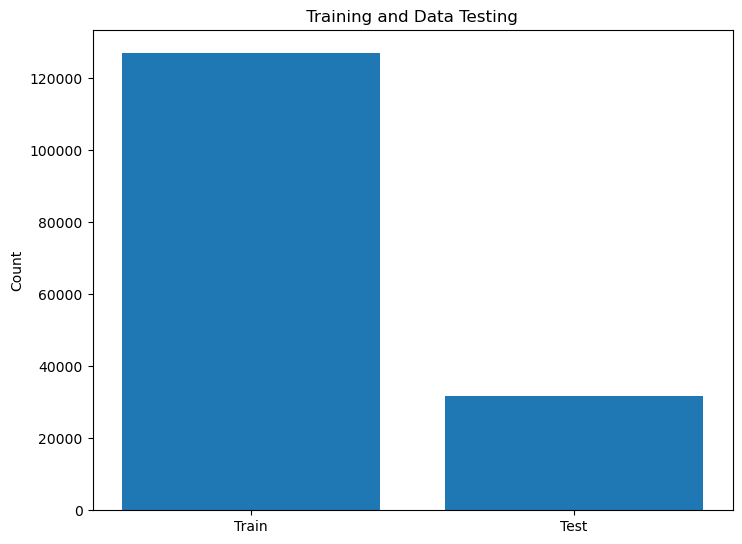

In [24]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
data_type = ['Train','Test']
counts = [trainingData.count(),testData.count()]
ax.bar(data_type,counts)
plt.title(" Training and Data Testing ")
plt.ylabel("Count")
plt.show()

In [25]:
li = []
for a in dataset.select(['Tweet2']).collect():
    li.append(len(a.Tweet2))
    
np.mean(li), np.max(li), np.min(li)

(13.127512760728465, 42, 0)

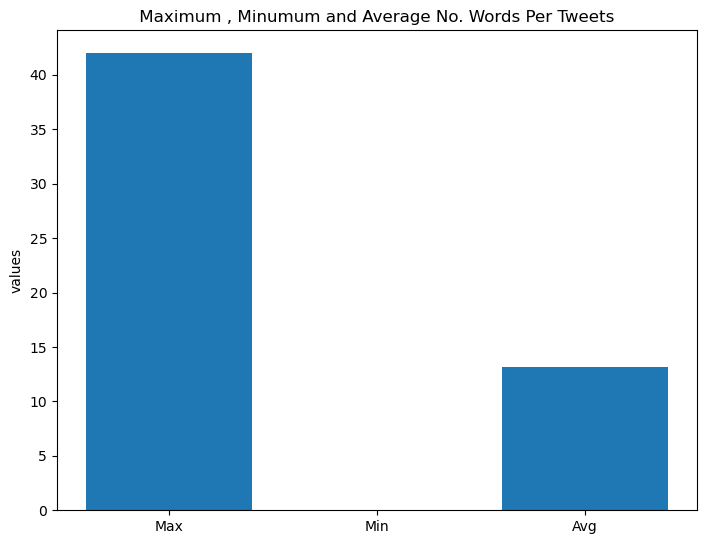

In [26]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
data= ['Max','Min','Avg']
values = [np.max(li),np.min(li),np.mean(li)]
ax.bar(data,values)
plt.title(" Maximum , Minumum and Average No. Words Per Tweets ")
plt.ylabel("values")
plt.show()

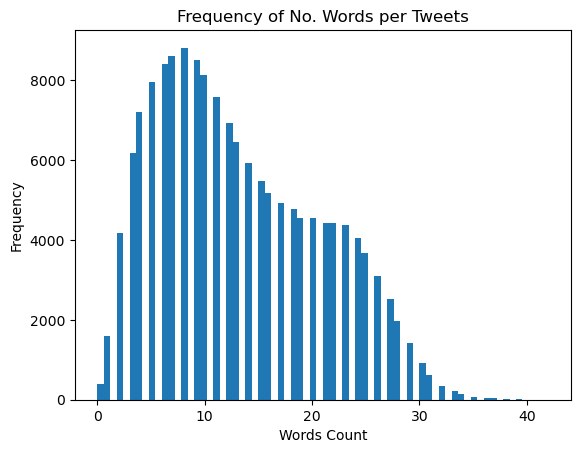

In [27]:
plt.hist(li, bins=70)
plt.xlabel('Words Count')
plt.ylabel('Frequency')
plt.title("Frequency of No. Words per Tweets")
plt.show()

### Model Building

##### We will try three models 
* Logestic Regression 
* Naiive Bayes
* Random Forest

In [28]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression( regParam=.12)
lrModel = lr.fit(trainingData)

predictions_test_log = lrModel.transform(testData)
predictions_train = lrModel.transform(trainingData)



In [29]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
train_logr_acc = evaluator.evaluate(predictions_train)
test_logr_acc = evaluator.evaluate(predictions_test_log)
print('Training Accuracy on LogisticRegression : {0}'.format(train_logr_acc))
print('Testing Accuracy on LogisticRegression : {0}'.format(test_logr_acc))


Training Accuracy on LogisticRegression : 0.8688439320024904
Testing Accuracy on LogisticRegression : 0.8443857497720341


##### Random Forest 

In [30]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier( labelCol="label", seed=42,
    leafCol="label1")
model = rf.fit(trainingData)

In [31]:
predictions_test = model.transform(testData)
predictions_train = model.transform(trainingData)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
train_ranf_acc = evaluator.evaluate(predictions_train)
test_ranf_acc = evaluator.evaluate(predictions_test)
print('Training Accuracy on RandomForestClassifier : {0}'.format(train_ranf_acc))
print('Testing Accuracy on RandomForestClassifier : {0}'.format(test_ranf_acc))


Training Accuracy on RandomForestClassifier : 0.44492343581296745
Testing Accuracy on RandomForestClassifier : 0.44134201175989685


##### NaiveBayes 

In [32]:
from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(smoothing=2)
model_nb = nb.fit(trainingData)
predictions_test = model_nb.transform(testData)
predictions_train = model_nb.transform(trainingData)


In [33]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
# evaluator_train = MulticlassClassificationEvaluator(predictionCol="prediction")
train_naiveb_acc = evaluator.evaluate(predictions_train)
test_naiveb_acc = evaluator.evaluate(predictions_test)
print('Training Accuracy on NaiveBayes : {0}'.format(train_naiveb_acc))
print('Testing Accuracy on NaiveBayes : {0}'.format(test_naiveb_acc))


Training Accuracy on NaiveBayes : 0.7872438008311623
Testing Accuracy on NaiveBayes : 0.7619907513119497


#### Comparison between Algorithms

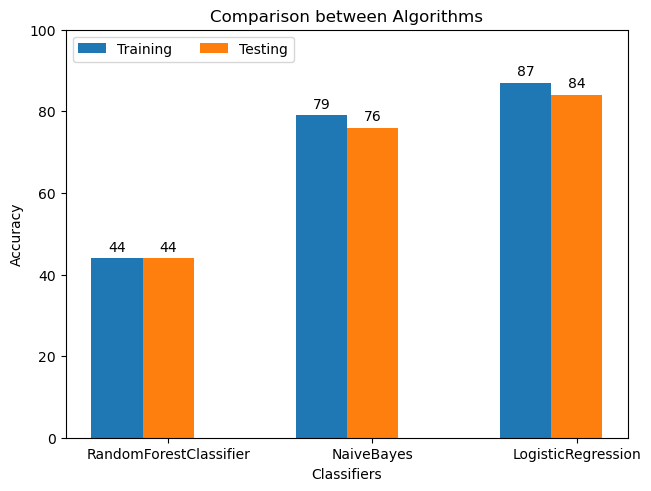

In [34]:
classifiers = ("RandomForestClassifier", "NaiveBayes", "LogisticRegression")
data = {
    'Training': (round(train_ranf_acc*100), round(train_naiveb_acc*100), round(train_logr_acc*100)),
    'Testing': ( round(test_ranf_acc*100), round(test_naiveb_acc*100), round(test_logr_acc*100))
}

x = np.arange(len(classifiers))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(constrained_layout=True)

for attribute, measurement in data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_xlabel('Classifiers')
ax.set_title('Comparison between Algorithms')
ax.set_xticks(x + width, classifiers)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 100)

plt.show()

#### Visualizing Evaluation Metrics for Logistic Regression

In [35]:
eval_accuracy = MulticlassClassificationEvaluator(labelCol="label",
                                                  predictionCol="prediction",
                                                  metricName="accuracy")

eval_precision = MulticlassClassificationEvaluator(labelCol="label",
                                                   predictionCol="prediction",
                                                   metricName="precisionByLabel")

eval_recall = MulticlassClassificationEvaluator(labelCol="label", 
                                                predictionCol="prediction", 
                                                metricName="recallByLabel")

eval_f1 = MulticlassClassificationEvaluator(labelCol="label", 
                                            predictionCol="prediction", 
                                            metricName="f1")

# get the evaluation metrics values
accuracy = eval_accuracy.evaluate(predictions_test_log)
precision = eval_precision.evaluate(predictions_test_log)
recall = eval_recall.evaluate(predictions_test_log)
f1score = eval_f1.evaluate(predictions_test_log)


In [36]:
print(f"the Accuracy of LogisticRegression: {round(accuracy * 100, 2)}%")
print(f"the precision of LogisticRegression: {round(precision* 100, 2)}%")
print(f"the recall of LogisticRegression: {round(recall* 100, 2)}%")
print(f"the f1score of LogisticRegression: {round(f1score* 100, 2)}%")

the Accuracy of LogisticRegression: 84.44%
the precision of LogisticRegression: 87.44%
the recall of LogisticRegression: 85.57%
the f1score of LogisticRegression: 84.2%


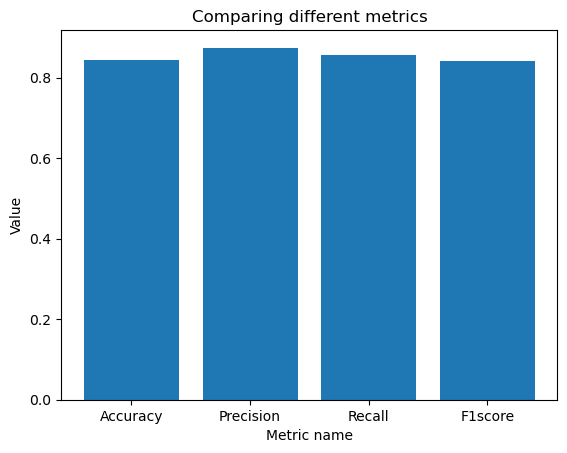

In [37]:
metric_name = ['Accuracy','Precision', 'Recall', 'F1score']
values = [accuracy, precision, recall, f1score]
plt.bar(metric_name,values)
plt.title("Comparing different metrics")
plt.xlabel("Metric name")
plt.ylabel("Value")
plt.show()